In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_curve, auc

def plot_pip(
    s_list, r_list, meta_data, figsize = (10,8),
    bbox = None, # (500, 800, 200) as X, Y for top left corner and side
    **kwargs
    ):
    pip_all = np.unique([x for p in s_list for x in p])
    receivers_all = [r_list[i] for i in range(len(r_list)) if len(s_list[i])>0]
    plot_data = meta_data.copy()
    plot_data['dot_size'] = 10
    plot_data.Celltype.replace(
        'Receivers','Out-of-range Receiver Cell Type', inplace = True)
    plot_data.Celltype.replace(
        'Senders','Out-of-range Sender Cell Type', inplace = True)
    plot_data.iloc[pip_all,2] = 'Sender Cell'
    plot_data.iloc[receivers_all,2] = 'Receiver Cell'
    plot_data.iloc[pip_all,5] = 50
    plot_data.iloc[receivers_all,5] = 50
    if bbox is not None:
        X_min, Y_min, delta = bbox
        mask = (plot_data.X >= X_min) & (plot_data.X <= X_min + delta)
        mask = mask & (plot_data.Y >= Y_min) & (plot_data.Y <= Y_min + delta)
        plot_data = plot_data[mask]
        receivers_mask = [
            True if x in plot_data.index else False for x in r_list]
        r_list = np.array(r_list)[receivers_mask]
        s_list = np.array(s_list, dtype="object")[receivers_mask]
        plot_data.dot_size = plot_data.dot_size * 10

    _ = plt.figure(figsize=figsize)
    sns.scatterplot(
        data = plot_data, x = 'X', y = 'Y', hue='Celltype', linewidth=0,
        size = 'dot_size',
        sizes = (25,150),
        hue_order = [
            'Others', 'Out-of-range Receiver Cell Type', 'Receiver Cell',
       'Out-of-range Sender Cell Type', 'Sender Cell'],
       **kwargs
       )
    plt.legend(bbox_to_anchor = (1,0.5), loc = 'center left')

    for i in range(len(r_list)):
        if len(s_list[i]) == 0:
            continue
        else:
            r = r_list[i]
            p = s_list[i]
            for indiv_p in p:
                try:
                    start = plot_data.loc[indiv_p,:'Y']
                    end = plot_data.loc[r,:'Y']
                except KeyError:
                    continue
                dx, dy = end-start
                plt.arrow(
                    *start, dx, dy,
                    head_width = 5,
                    length_includes_head=True, 
                    edgecolor=None,
                    color = 'k')

In [2]:
sns.set_theme('paper', font = 'Arial', font_scale=1.5, style='white')
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["legend.markerscale"] = 2
colors = sns.color_palette("bright").as_hex()

In [3]:
base_input = 'demo_data/base_10_pathways'
noised_input = 'demo_data/noise_level_0.5_5_pathways'
# Retrieve simulated data, including true beta values and primary instance scores
# Metadata containing cell type, coordinates of simulated cells. The last two columns are cell ids.
meta_data = pd.read_csv(
    os.path.join(base_input,'simulation_metadata.txt'), index_col=0, sep='\t')
# get receiver cells
receivers = meta_data.dropna(subset = ['Sender_cells']).index
# get sender cells
candidate_senders = meta_data.loc[receivers,'Sender_cells'].str.split(',').tolist()
# True sender cells 
true_senders = meta_data.loc[receivers,'Sender_cells_PI'].str.split(',').tolist()
# Reformat candidate senders and true senders into list of lists.
true_senders = [[] if isinstance(x, float) else x for x in true_senders]
candidate_senders = [list(map(lambda x: int(x), y)) for y in candidate_senders]
true_senders = [list(map(lambda x: int(x), y)) for y in true_senders]
# Reads the beta values for all 50 simulated genes
true_beta = pd.read_csv(os.path.join(base_input, 'betas.csv'))

In [4]:
# The first 10 genes are signaling sending, and thus have the 'True_beta' tags.
# The rest are trivial genes, with very small beta values.
print(true_beta.head(20))

      Unnamed: 0        Val
0      True_beta -10.399465
1      True_beta  12.078322
2      True_beta -13.064702
3      True_beta  17.122011
4      True_beta  13.126023
5      True_beta  18.283505
6      True_beta  23.883729
7      True_beta -19.343043
8      True_beta -11.693603
9      True_beta  14.878722
10  Trivial_beta  -1.185296
11  Trivial_beta  -0.524335
12  Trivial_beta  -0.784061
13  Trivial_beta   0.734260
14  Trivial_beta   0.250681
15  Trivial_beta  -1.507312
16  Trivial_beta  -0.340504
17  Trivial_beta   1.062332
18  Trivial_beta  -0.631028
19  Trivial_beta   1.076862


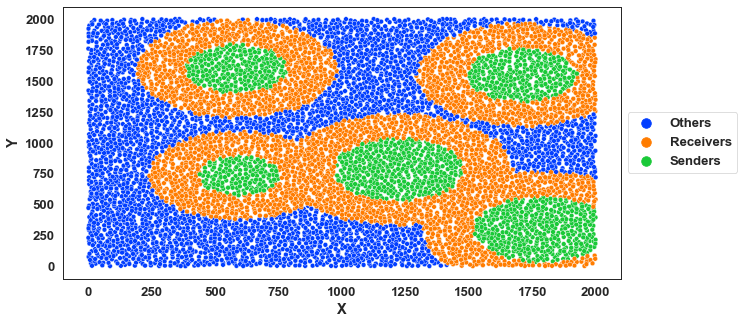

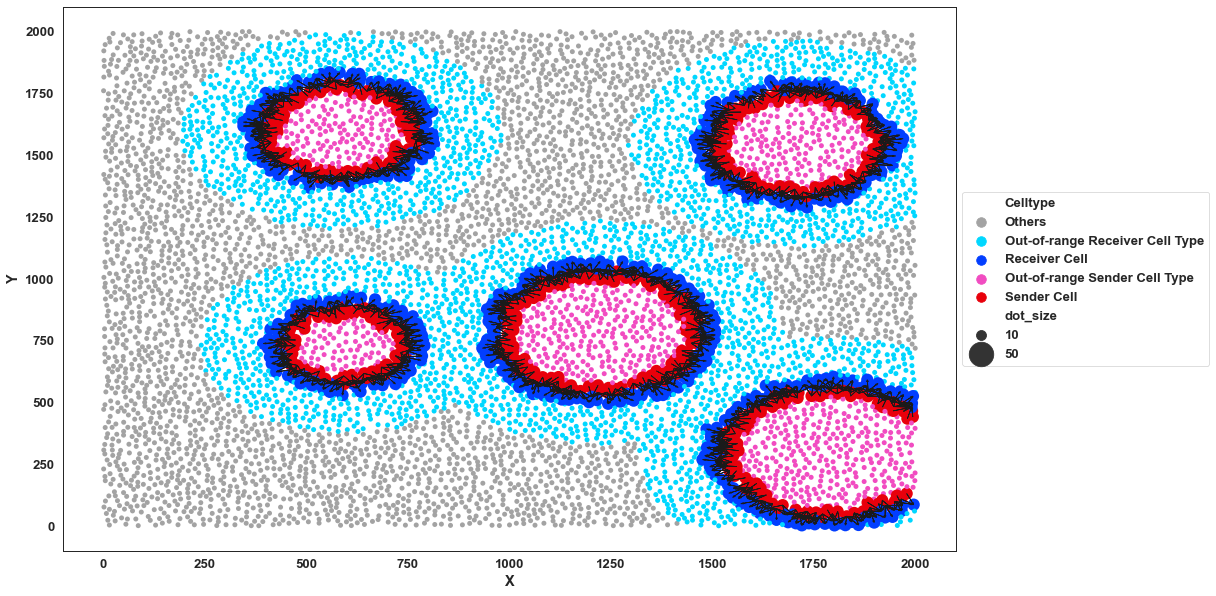

In [5]:
# Let's look at the simulation data and the interactions 
_ = plt.figure(figsize=(10,5))
sns.scatterplot(
    data = meta_data, x = 'X', y = 'Y', hue='Celltype', palette=colors[:3])
plt.legend(bbox_to_anchor = (1, 0.5), loc = 'center left')

# Plotting interactions between receiver and sender cells
plot_colors = [colors[i] for i in [7,9,0,6,3]]
plot_pip(
    true_senders, receivers, meta_data, figsize=(16,10),
    palette=plot_colors)

In [6]:
# Next we will assess Spacia's predictions.
# read spacia results
job_id = 'spacia_base_10_pathways_Ntotal_50000_Nwarm_20000_Nthin_100'
pred_b = pd.read_csv(
    os.path.join(base_input, job_id, job_id + '_b.txt'), sep='\t')
res_beta = pd.read_csv(
    os.path.join(base_input, job_id, job_id + '_beta.txt'), sep='\t')
fdr = pd.read_csv(
    os.path.join(base_input, job_id, job_id + '_FDRs.txt'), sep='\t')
pip_res = pd.read_csv(
    os.path.join(base_input, job_id, job_id + '_pip_recal.txt'), sep='\t')

No handles with labels found to put in legend.


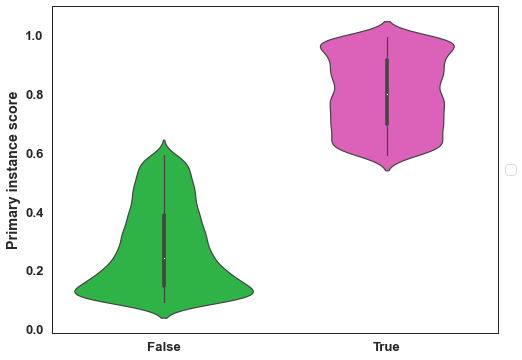

In [7]:
# Plot primary instance scores for true senders and false senders
pi_vector = []
for i, s in enumerate(candidate_senders):
    pi_vector += [True if x in true_senders[i] else False for x in candidate_senders[i]]
pip_res['Primary_instance'] = pi_vector
_ = plt.figure(figsize=(8,6))
sns.violinplot(
    data = pip_res, x = 'Primary_instance', y = 'pip_recal',
    palette = [colors[2],colors[6]])
plt.xlabel('')
plt.ylabel('Primary instance score')
plt.legend(bbox_to_anchor = (1,0.5), loc = 'center left')

Text(0.5, 0, 'Predicted Beta')

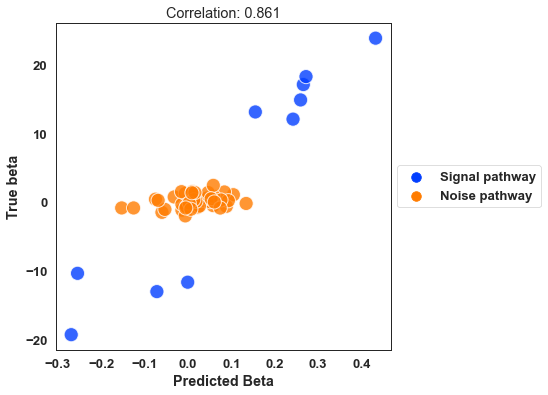

In [8]:
# Plotting true beta values vs predicted beta values
all_chains_mean = res_beta.mean().to_frame(name='Predicted')
all_chains_mean['True beta'] = true_beta.iloc[:,1].tolist()
cor = all_chains_mean.corr().iloc[0,1]
_ = plt.figure(figsize=(6,6))
plotdata = all_chains_mean.copy()
plotdata['Beta type'] = ['Signal pathway'] * 10 + ['Noise pathway'] * 40
sns.scatterplot(
    data = plotdata, x = 'Predicted', y = 'True beta', hue = 'Beta type',
    s = 200, alpha = 0.8, linewidth = 1, palette='bright')
plt.legend(
    bbox_to_anchor = (1,0.5), loc = 'center left', markerscale=2)
plt.title('Correlation: {:.3f}'.format(cor))
plt.xlabel('Predicted Beta')
# plt.savefig(simulation_output + '/Beta correlation 10 pathways.pdf')

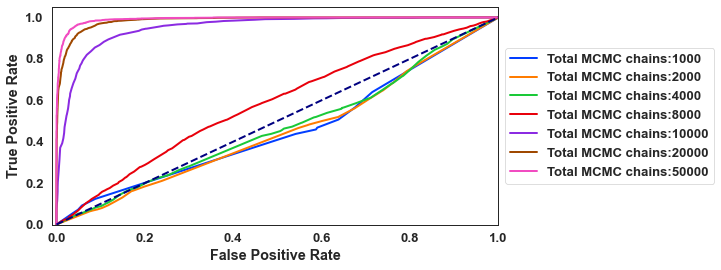

In [9]:
# In this test, we added noise under normal distribution with mean = 0 and std = 0.5 to sender expression.
# We ran Spacia with different number of chains, and evaluate if Spacia is robust against noise.
# Accuracy of Spacia is evaluated using primary instance prediction accuracy.

## setting up paths to spacia results
folders = [
    'spacia_noise_level_0.5_5_pathways_Ntotal_1000_Nwarm_500_Nthin_100',
    'spacia_noise_level_0.5_5_pathways_Ntotal_2000_Nwarm_1000_Nthin_100',
    'spacia_noise_level_0.5_5_pathways_Ntotal_4000_Nwarm_2000_Nthin_100',
    'spacia_noise_level_0.5_5_pathways_Ntotal_8000_Nwarm_4000_Nthin_100',
    'spacia_noise_level_0.5_5_pathways_Ntotal_10000_Nwarm_5000_Nthin_100',
    'spacia_noise_level_0.5_5_pathways_Ntotal_20000_Nwarm_10000_Nthin_100',
    'spacia_noise_level_0.5_5_pathways_Ntotal_50000_Nwarm_20000_Nthin_100',
]
fpr = dict()
tpr = dict()
roc_auc = dict()
labels = []
for k, fd in enumerate(folders):
    labels.append(fd.split('_')[7])
    pip_res = pd.read_csv(
        os.path.join(noised_input,fd, fd + '_pip.txt'), sep='\t')
    plotdata = pip_res.mean(axis=1).to_frame(name = 'PI_score')
    # Since the sender and receivers is the same as the base simulation, we can safely use the pi_vector from previous results.
    plotdata['Primary_instance'] = pi_vector
    # Calculate true positive and false positive rates.
    fpr[k], tpr[k], _ = roc_curve(plotdata.Primary_instance, plotdata.PI_score)
    roc_auc[k] = auc(fpr[k], tpr[k])

# Plotting ROC curves
plt.figure(figsize=(8,4))
lw = 2
for i, label in enumerate(labels):
    plt.plot(
        fpr[i],
        tpr[i],
        color=colors[i],
        lw=lw,
        label= 'Total MCMC chains:' + str(label),
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(bbox_to_anchor = (1, 0.5), loc="center left")